# Variable Depth

In [ ]:
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
import scipy.interpolate

# use the CAMB cosmology that generated the matter power spectra
import camb
from cosmology import Cosmology

# almost all GLASS functionality is available from the `glass` namespace
import glass
import glass.ext.camb

# creating a numpy random number generator for sampling
rng = np.random.default_rng(seed=42)

# cosmology for the simulation
h = 0.7
Oc = 0.25
Ob = 0.05

# basic parameters of the simulation
nside = lmax = 128

# set up CAMB parameters for matter angular power spectrum
pars = camb.set_params(
    H0=100 * h,
    omch2=Oc * h**2,
    ombh2=Ob * h**2,
    NonLinear=camb.model.NonLinear_both,
)

# get the cosmology from CAMB
cosmo = Cosmology.from_camb(pars)

# shells of 200 Mpc in comoving distance spacing
zb = glass.distance_grid(cosmo, 0.0, 3.0, dx=200.0)

zbins = [(zb[i], zb[i + 1]) for i in range(len(zb) - 1)]

# tophat window function for shells
ws = glass.tophat_windows(zb)

In [ ]:
# compute the angular matter power spectra of the shells with CAMB
cls = glass.ext.camb.matter_cls(pars, lmax, ws)

In [ ]:
cls = glass.discretized_cls(cls, nside=nside, lmax=lmax, ncorr=3)

fields = glass.lognormal_fields(ws)

gls = glass.solve_gaussian_spectra(fields, cls)

In [ ]:
# generator for lognormal matter fields
matter = glass.generate(fields, gls, nside, ncorr=3, rng=rng)

# this will compute the convergence field iteratively
convergence = glass.MultiPlaneConvergence(cosmo)

Read in survey properties

In [ ]:
# galaxy density in each tomographic bin
n_arcmin2 = np.array([0.62, 1.18, 1.85, 1.26, 1.31])  # per arcmin^2

# instrinsic galaxy shape dispersion per tomographic bin
sigma_e = np.array([0.2721, 0.2608, 0.2767, 0.2534, 0.2684])

# tomographic redshift bins
nbins = 5

ztomo = [
    (0.1, 0.3),
    (0.3, 0.5),
    (0.5, 0.7),
    (0.7, 0.9),
    (0.9, 1.2),
]


# photometric redshift error
sigma_z0 = 0.03

# true redshift distribution following a Smail distribution

z_resolution = 1000
z_grid = np.linspace(0, 5, z_resolution)

nz_noise = np.absolute(0.06 * rng.normal(size=(nbins, z_resolution)))
nz_precision = 0.001

# create 5 tomographic redshift bins with a Smail distribution
dndz = glass.smail_nz(z_grid, z_mode=0.9, alpha=2.0, beta=1.5)

tomo_nz = (
    glass.tomo_nz_gausserr(z_grid, dndz, sigma_z0, ztomo) + nz_noise + nz_precision
)

dndz *= np.sum(n_arcmin2)
tomo_nz /= np.trapezoid(tomo_nz, z_grid, axis=1)[:, None]
tomo_nz *= n_arcmin2[:, None]

# assume linear galaxy bias
bias = 1

# create stage-IV-like mask
vis = glass.vmap_galactic_ecliptic(nside)
mask = vis
mask[mask < 0.5] = np.repeat(0, len(mask[mask < 0.5]))
mask[mask >= 0.5] = np.repeat(1, len(mask[mask >= 0.5]))

In [ ]:
# create mock variable depth map of a dipole
fake_cl = np.zeros(12 * nside**2)
fake_cl[1] = 1
contrast = hp.synfast(fake_cl, nside)

maximum_contrast = 4.8
minimum_contrast = 2.9
contrast = (maximum_contrast - minimum_contrast) * (contrast - np.min(contrast)) / (
    np.max(contrast) - np.min(contrast)
) + minimum_contrast

vd_map = vd_z_map = contrast * mask

vd_map = vd_map[None, :]  # add a dummy dimension for the number of tomographic bins

# KiDS-1000-like galaxy density calibration
a_n_gal = np.array([-0.035002, -0.041813, -0.242983, -0.250177, -0.416808])
b_n_gal = np.array([0.717425, 1.300479, 2.577931, 2.010033, 2.564117])

# define galaxy density calibration function for each tomographic bin
n_contrast_vd_func = [
    lambda x, i=i: (a_n_gal[i] * x + b_n_gal[i]) / n_arcmin2[i] for i in range(nbins)
]

# variable depth bins
vd_trace = np.array(
    [
        2.2286181,
        2.463833,
        2.6889505,
        2.918945,
        3.1485405,
        3.3923588,
        3.6255658,
        3.86079,
        4.0923247,
        4.5383224,
    ],
)

# shift redshift distributions by up to z=+/-0.05
vd_z_shift = (
    0.1 * (vd_trace - np.min(vd_trace)) / (np.max(vd_trace) - np.min(vd_trace)) - 0.05
)
vd_z_shift = vd_z_shift[::-1]

n_vardepth_bins = 10
dndz_vd = np.zeros((nbins, n_vardepth_bins, z_resolution))

for i in range(nbins):
    for j in range(n_vardepth_bins):
        interp_func = scipy.interpolate.interp1d(
            z_grid,
            tomo_nz[i] / np.trapezoid(tomo_nz[i], z_grid),
            fill_value="extrapolate",
        )
        z_grid_shifted = z_grid + vd_z_shift[j]
        dndz_vd[i, j] = interp_func(z_grid_shifted) + nz_noise[i] + nz_precision
        dndz_vd[i, j][(z_grid < 0.05)] = nz_noise[i][(z_grid < 0.05)] + nz_precision
        dndz_vd[i, j] /= np.trapezoid(dndz_vd[i, j], z_grid)

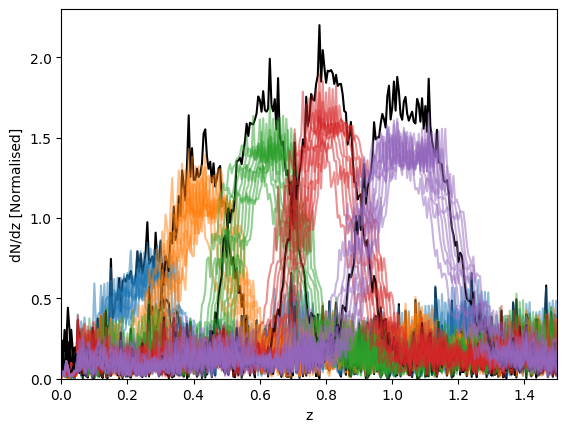

In [ ]:
for i in range(nbins):
    plt.plot(z_grid, tomo_nz[i] / n_arcmin2[i], label=f"bin {i}", c="k")
    for j in range(n_vardepth_bins):
        plt.plot(
            z_grid,
            dndz_vd[i, j],
            label=f"bin {i}, vd {j}",
            alpha=0.5,
            color=f"C{i}",
        )
plt.xlim(0, 1.5)
plt.ylim(0, 2.3)
plt.xlabel("z")
plt.ylabel("dN/dz [Normalised]");

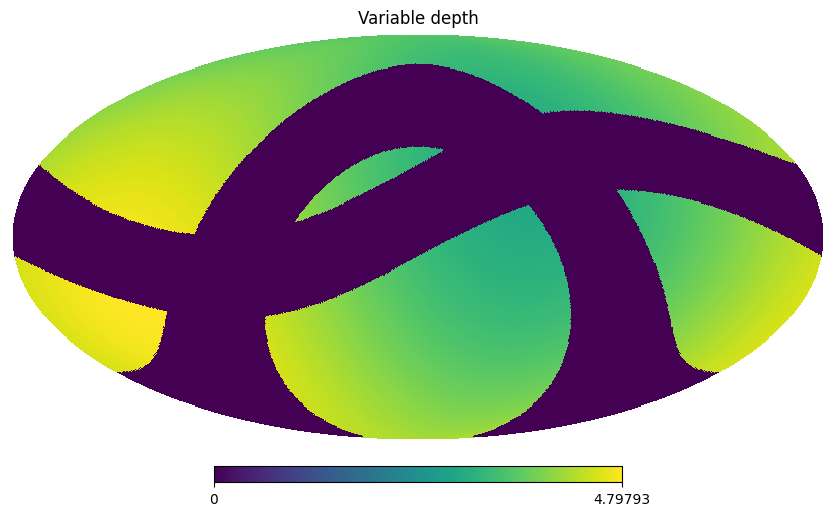

In [ ]:
hp.mollview(vd_map[0], title="Variable depth")

In [ ]:
var_depth_mask = glass.observations.AngularLosVariableDepthMask(
    # variable depth map in the ANGULAR direction for all tomographicbins
    vd_map,
    # number of tomographic bins
    n_bins=nbins,
    # redshift shell bin edges
    zbins=zbins,
    # redshift bin edges for each tomographic bin
    ztomo=ztomo,
    # dndz for each tomographic bin
    dndz=tomo_nz / n_arcmin2[:, None],
    # redshift grid
    z=z_grid,
    # redshift distribution per tomographic bin per variable depth bin
    dndz_vardepth=dndz_vd,
    # variable depth grid
    vardepth_values=vd_trace,
    # variable depth map in the REDSHIFT direction for all tomographic bins
    vardepth_los_tracer=vd_z_map,
    # functions to map tracer to n_gal variation due to variable
    # depth per tomographic bins
    vardepth_tomo_functions=n_contrast_vd_func,
)

Tomographic bin 0, redshift bin 0
0.21484558132298082
0.0


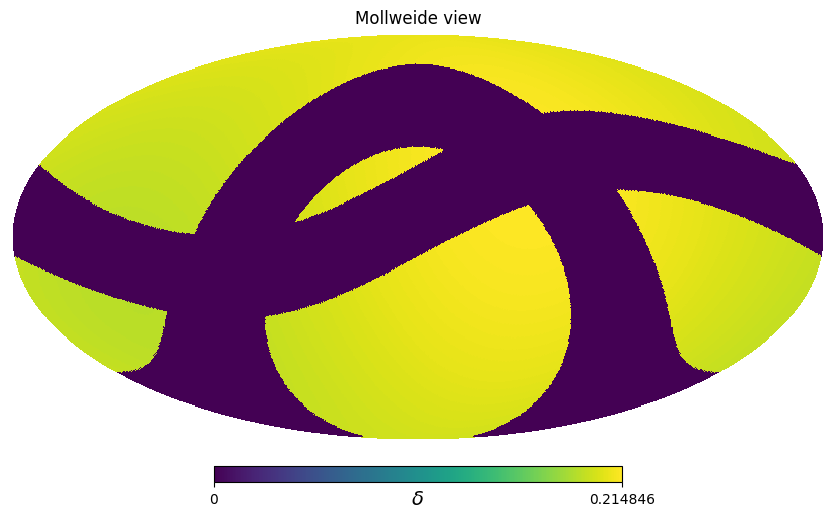

In [ ]:
i, j = 0, 0
print(f"Tomographic bin {i}, redshift bin {j}")
print(np.max(var_depth_mask[i, j] * mask))
print(np.min(var_depth_mask[i, j] * mask))
hp.mollview(var_depth_mask[i, j] * mask, unit=r"$\delta$")

In [ ]:
# we will store the catalogue as a structured numpy array, initially empty
catalogue = np.empty(
    0,
    dtype=[
        ("RA", float),
        ("DEC", float),
        ("Z_TRUE", float),
        ("ZBIN", int),
        ("G1", float),
        ("G2", float),
    ],
)

# simulate the matter fields in the main loop, and build up the catalogue
for i, delta_i in enumerate(matter):
    # compute the lensing maps for this shell
    convergence.add_window(delta_i, ws[i])
    kappa_i = convergence.kappa
    gamm1_i, gamm2_i = glass.shear_from_convergence(kappa_i)

    for tomo in range(nbins):
        # the true galaxy distribution in this shell
        z_i, dndz_i = glass.restrict(z_grid, tomo_nz[tomo], ws[i])

        # integrate dndz to get the total galaxy density in this shell
        ngal = np.trapezoid(dndz_i, z_i)

        effective_mask = mask * var_depth_mask[tomo, i]
        # generate galaxy positions from the matter density contrast
        for gal_lon, gal_lat, gal_count in glass.points.positions_from_delta(
            ngal,
            delta_i,
            bias,
            effective_mask,
        ):
            # generate random redshifts from the provided nz
            gal_z = glass.redshifts_from_nz(gal_count, z_i, dndz_i, rng=rng, warn=False)

            # generate galaxy ellipticities from the chosen distribution
            gal_eps = glass.ellipticity_intnorm(gal_count, sigma_e[tomo])

            # apply the shear fields to the ellipticities
            gal_she = glass.galaxy_shear(
                gal_lon,
                gal_lat,
                gal_eps,
                kappa_i,
                gamm1_i,
                gamm2_i,
            )

            # make a mini-catalogue for the new rows
            rows = np.empty(gal_count, dtype=catalogue.dtype)
            rows["RA"] = gal_lon
            rows["DEC"] = gal_lat
            rows["Z_TRUE"] = gal_z
            rows["ZBIN"] = tomo
            rows["G1"] = gal_she.real
            rows["G2"] = gal_she.imag

            # add the new rows to the catalogue
            catalogue = np.append(catalogue, rows)

print(f"Total number of galaxies sampled: {len(catalogue):,}")

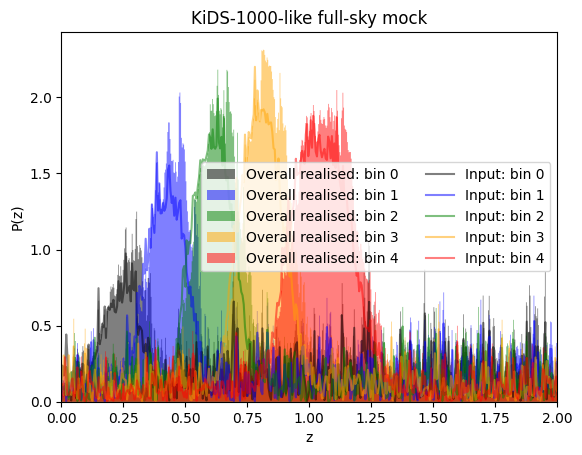

In [ ]:
# redshift distribution of tomographic bins & input distributions
plt.figure()
plt.ylabel("P(z)")
plt.title("KiDS-1000-like full-sky mock")

color = ["k", "b", "g", "orange", "r"]

plt.xlabel("z")
for i in range(nbins):
    in_bin = catalogue["ZBIN"] == i
    plt.hist(
        catalogue["Z_TRUE"][in_bin],
        histtype="stepfilled",
        density=1,
        edgecolor="none",
        color=color[i],
        alpha=0.5,
        bins=1000,
        label=f"Overall realised: bin {i}",
    )
for i in range(nbins):
    plt.plot(
        z_grid,
        tomo_nz[i] / n_arcmin2[i],
        alpha=0.5,
        label=f"Input: bin {i}",
        color=color[i],
    )
plt.xlim([0, 3])
plt.legend(ncol=2, fontsize=10);